In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report,
                             mean_squared_error, r2_score, brier_score_loss)
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [ ]:
# 2.1 Wczytanie z pliku CSV
df_raw = pd.read_csv("bundesliga_filtered.csv")

# 2.2 Podstawowy przegląd
print("=== Podgląd pierwszych wierszy ===")
print(df_raw.head(), "\n")

print("=== Informacje o kolumnach ===")
print(df_raw.info(), "\n")

print("=== Statystyki opisowe (liczbowe) ===")
print(df_raw.describe(), "\n")


=== Podgląd pierwszych wierszy ===
       league  season h_a       xG       xGA     npxG     npxGA  deep  \
0  Bundesliga    2014   h  2.57012  1.198420  2.57012  1.198420     5   
1  Bundesliga    2014   a  1.19842  2.570120  1.19842  2.570120     4   
2  Bundesliga    2014   h  1.17979  0.956665  1.17979  0.956665     4   
3  Bundesliga    2014   h  1.52873  0.280777  1.52873  0.280777     6   
4  Bundesliga    2014   a  1.38084  1.753310  1.38084  1.753310    13   

   deep_allowed  scored  ...  ppda_coef  ppda_att ppda_def oppda_coef  \
0             4       2  ...   9.625000       231       24  21.850000   
1             5       1  ...  21.850000       437       20   9.625000   
2             3       2  ...   9.642857       270       28   6.055556   
3             2       2  ...   6.588235       224       34   5.739130   
4             3       0  ...   3.465116       149       43  10.517241   

   oppda_att  oppda_def           team  xG_diff  xGA_diff  xpts_diff  
0        437    

In [30]:
# 3.1 Filtrowanie do Bundesligi
df = df_raw[df_raw['league'] == 'Bundesliga'].copy()

# 3.2 Usunięcie duplikatów
df.drop_duplicates(inplace=True)

# 3.3 Usuwanie rekordów z brakami w kluczowych kolumnach
key_cols = ['season', 'team', 'h_a', 'scored', 'xG', 'xGA', 'result']
df.dropna(subset=key_cols, inplace=True)

print("Rozmiar po czyszczeniu:", len(df))
print("Kolumny w DataFrame:", list(df.columns))


Rozmiar po czyszczeniu: 6464
Kolumny w DataFrame: ['league', 'season', 'h_a', 'xG', 'xGA', 'npxG', 'npxGA', 'deep', 'deep_allowed', 'scored', 'missed', 'xpts', 'result', 'date', 'wins', 'draws', 'loses', 'pts', 'npxGD', 'ppda_coef', 'ppda_att', 'ppda_def', 'oppda_coef', 'oppda_att', 'oppda_def', 'team', 'xG_diff', 'xGA_diff', 'xpts_diff']


In [31]:
df_history = df[df['season'] < 2023].copy()
grouped = df_history.groupby(['team', 'h_a'])['scored'].mean().reset_index()
grouped.rename(columns={'scored': 'avg_goals'}, inplace=True)

strength_df = grouped.pivot(index='team', columns='h_a', values='avg_goals').reset_index()
strength_df.rename(columns={'h': 'home_strength', 'a': 'away_strength'}, inplace=True)

print("=== Tabela strength_df - przykładowe wiersze ===")
print(strength_df)



=== Tabela strength_df - przykładowe wiersze ===
h_a                    team  away_strength  home_strength
0         Arminia Bielefeld       0.735294       0.823529
1                  Augsburg       1.043210       1.411043
2          Bayer Leverkusen       1.672840       1.987730
3             Bayern Munich       2.269939       3.117284
4                    Bochum       0.818182       1.372093
5         Borussia Dortmund       1.740741       2.607362
6       Borussia M.Gladbach       1.327160       1.950920
7                 Darmstadt       0.970588       0.970588
8       Eintracht Frankfurt       1.306748       1.808642
9                FC Cologne       1.161765       1.367647
10            FC Heidenheim       1.600000       0.888889
11      Fortuna Duesseldorf       1.176471       1.323529
12                 Freiburg       1.123288       1.565517
13          Greuther Fuerth       0.764706       0.882353
14             Hamburger SV       0.779412       1.088235
15              Hannove

In [32]:
new_teams = ['St. Pauli', 'Holstein Kiel', 'FC Heidenheim']

# Jeśli nie istnieją, dodajemy wiersze
rows_to_add = []
for nt in new_teams:
    if nt not in strength_df['team'].unique():
        rows_to_add.append({'team': nt, 'home_strength': 1.0, 'away_strength': 1.0})

if rows_to_add:
    strength_df = pd.concat([strength_df, pd.DataFrame(rows_to_add)], ignore_index=True)

# Następnie wymuszamy = 1.0
strength_df.loc[strength_df['team'] == 'St. Pauli', ['home_strength', 'away_strength']] = 1.0
strength_df.loc[strength_df['team'] == 'Holstein Kiel', ['home_strength', 'away_strength']] = 1.0

print("\n=== Sprawdzamy wiersze dla St. Pauli i Holstein Kiel ===")
print(strength_df[strength_df['team'].isin(new_teams)])



=== Sprawdzamy wiersze dla St. Pauli i Holstein Kiel ===
h_a           team  away_strength  home_strength
10   FC Heidenheim            1.6       0.888889
18   Holstein Kiel            1.0       1.000000
25       St. Pauli            1.0       1.000000


In [33]:
df_merged = pd.merge(df, strength_df, on='team', how='left')

# Kolumna home
df_merged['home'] = df_merged['h_a'].apply(lambda x: 1 if x == 'h' else 0)

# Kolumna strength
df_merged['strength'] = np.where(
    df_merged['h_a'] == 'h',
    df_merged['home_strength'],
    df_merged['away_strength']
)

print("\n=== df_merged - przykładowe kolumny ===")
print(df_merged[['team', 'season', 'h_a', 'home_strength', 'away_strength', 'strength']].tail(10))



=== df_merged - przykładowe kolumny ===
                     team  season h_a  home_strength  away_strength  strength
6454        Bayern Munich    2013   a       3.117284       2.269939  2.269939
6455        Werder Bremen    2013   a       1.410959       1.458904  1.458904
6456               Bochum    2013   a       1.372093       0.818182  0.818182
6457  Borussia M.Gladbach    2013   h       1.950920       1.327160  1.950920
6458           Hoffenheim    2013   h       1.791411       1.432099  1.791411
6459  Eintracht Frankfurt    2013   a       1.808642       1.306748  1.306748
6460         Union Berlin    2013   a       1.571429       1.115385  1.115385
6461            St. Pauli    2013   h       1.000000       1.000000  1.000000
6462        Werder Bremen    2013   h       1.410959       1.458904  1.410959
6463             Mainz 05    2013   a       1.503067       1.190184  1.190184


In [34]:
train_data = df_merged[df_merged['season'] < 2023].copy()
test_data  = df_merged[df_merged['season'] == 2023].copy()

print("Train size:", len(train_data), "Test size:", len(test_data))


Train size: 5852 Test size: 612


In [35]:
list(train_data.columns)


['league',
 'season',
 'h_a',
 'xG',
 'xGA',
 'npxG',
 'npxGA',
 'deep',
 'deep_allowed',
 'scored',
 'missed',
 'xpts',
 'result',
 'date',
 'wins',
 'draws',
 'loses',
 'pts',
 'npxGD',
 'ppda_coef',
 'ppda_att',
 'ppda_def',
 'oppda_coef',
 'oppda_att',
 'oppda_def',
 'team',
 'xG_diff',
 'xGA_diff',
 'xpts_diff',
 'away_strength',
 'home_strength',
 'home',
 'strength']

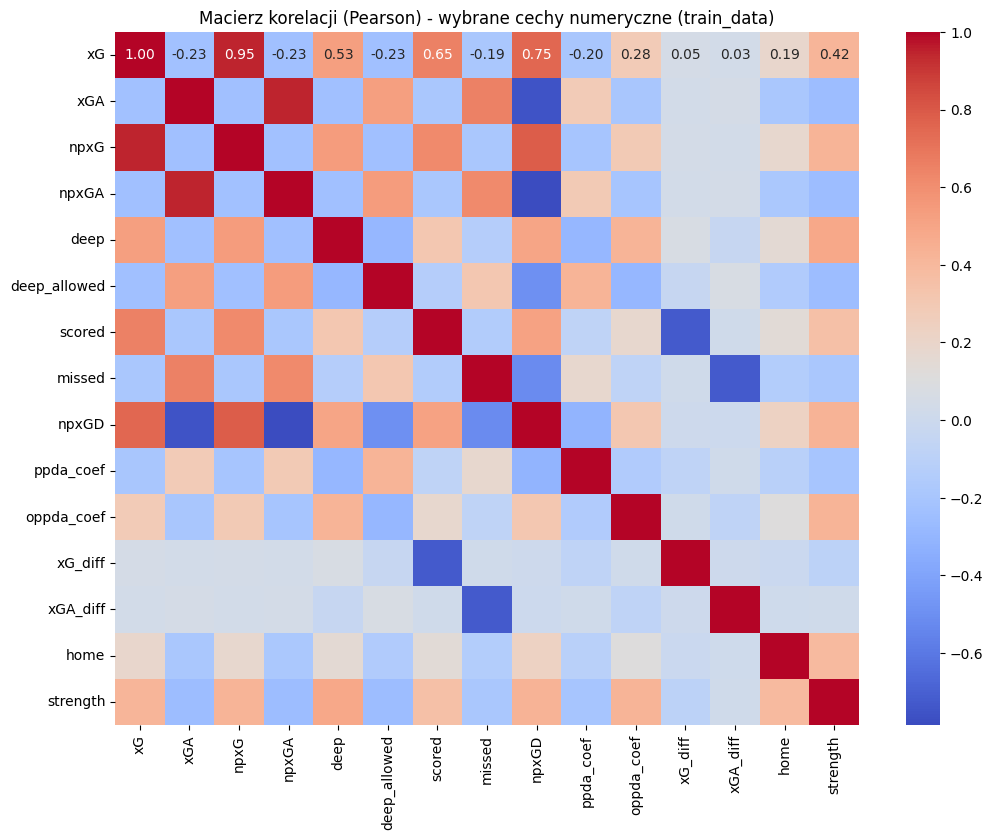

In [36]:
numeric_cols = [
    'xG', 'xGA', 'npxG', 'npxGA',
    'deep', 'deep_allowed',
    'scored', 'missed',
    'npxGD',
    'ppda_coef', 'oppda_coef',
    'xG_diff', 'xGA_diff',
    'home', 'strength'
]

df_corr = train_data[numeric_cols].dropna()
corr_matrix = df_corr.corr(method='pearson')

plt.figure(figsize=(12, 9))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Macierz korelacji (Pearson) - wybrane cechy numeryczne (train_data)")
plt.show()


In [38]:
features_classif = [
    'xG', 'xGA',
    'npxG', 'npxGA',
    'deep', 'deep_allowed',
    'ppda_coef', 'oppda_coef',
    'home', 'strength'
]
target_classif = 'result'

X_train_classif = train_data[features_classif].fillna(0)
X_test_classif  = test_data[features_classif].fillna(0)

y_train_classif = train_data[target_classif]
y_test_classif  = test_data[target_classif]

# LabelEncoder (W, D, L -> 0,1,2)
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train_classif)
y_test_enc  = le.transform(y_test_classif)


In [39]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_classif, y_train_enc)
y_pred_classif = clf.predict(X_test_classif)


In [40]:
#ewaluacja

acc = accuracy_score(y_test_enc, y_pred_classif)
cm = confusion_matrix(y_test_enc, y_pred_classif)

print("\n=== KLASYFIKACJA: Wynik meczu (W/D/L) ===")
print(f"Accuracy (sezon 2023): {acc:.3f}")
print("Confusion Matrix (kolejność klas):", le.classes_)
print(cm)
print("\nClassification report:")
print(classification_report(y_test_enc, y_pred_classif, target_names=le.classes_))



=== KLASYFIKACJA: Wynik meczu (W/D/L) ===
Accuracy (sezon 2023): 0.624
Confusion Matrix (kolejność klas): ['d' 'l' 'w']
[[ 27  68  67]
 [ 16 180  29]
 [ 16  34 175]]

Classification report:
              precision    recall  f1-score   support

           d       0.46      0.17      0.24       162
           l       0.64      0.80      0.71       225
           w       0.65      0.78      0.71       225

    accuracy                           0.62       612
   macro avg       0.58      0.58      0.55       612
weighted avg       0.59      0.62      0.59       612



In [41]:
y_proba_classif = clf.predict_proba(X_test_classif)
n_classes = len(le.classes_)
brier_scores = []

for i in range(n_classes):
    y_true_i = (y_test_enc == i).astype(int)
    y_prob_i = y_proba_classif[:, i]
    bs_i = brier_score_loss(y_true_i, y_prob_i)
    brier_scores.append(bs_i)

brier_score_multi = np.mean(brier_scores)
print(f"Brier score (multi-class, one-vs-rest): {brier_score_multi:.4f}")


Brier score (multi-class, one-vs-rest): 0.1685


In [42]:
#Zdobyte bramki

features_regr = [
    'xG', 'xGA',
    'npxG', 'npxGA',
    'deep', 'deep_allowed',
    'ppda_coef', 'oppda_coef',
    'home', 'strength'
]
target_regr = 'scored'

X_train_regr = train_data[features_regr].fillna(0)
y_train_regr = train_data[target_regr]
X_test_regr  = test_data[features_regr].fillna(0)
y_test_regr  = test_data[target_regr]


In [43]:
regr = RandomForestRegressor(n_estimators=100, random_state=42)
regr.fit(X_train_regr, y_train_regr)
y_pred_regr = regr.predict(X_test_regr)


In [44]:
mse = mean_squared_error(y_test_regr, y_pred_regr)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_regr, y_pred_regr)

print("\n=== REGRESJA: liczba goli (scored) ===")
print(f"RMSE (sezon 2023): {rmse:.3f}")
print(f"R^2 (sezon 2023): {r2:.3f}")



=== REGRESJA: liczba goli (scored) ===
RMSE (sezon 2023): 1.042
R^2 (sezon 2023): 0.406



=== Feature importance (RandomForest - klasyfikacja) ===
        feature  importance
0            xG    0.160668
1           xGA    0.159408
2          npxG    0.129728
3         npxGA    0.128257
7    oppda_coef    0.101373
6     ppda_coef    0.099101
9      strength    0.085000
5  deep_allowed    0.061576
4          deep    0.061195
8          home    0.013695


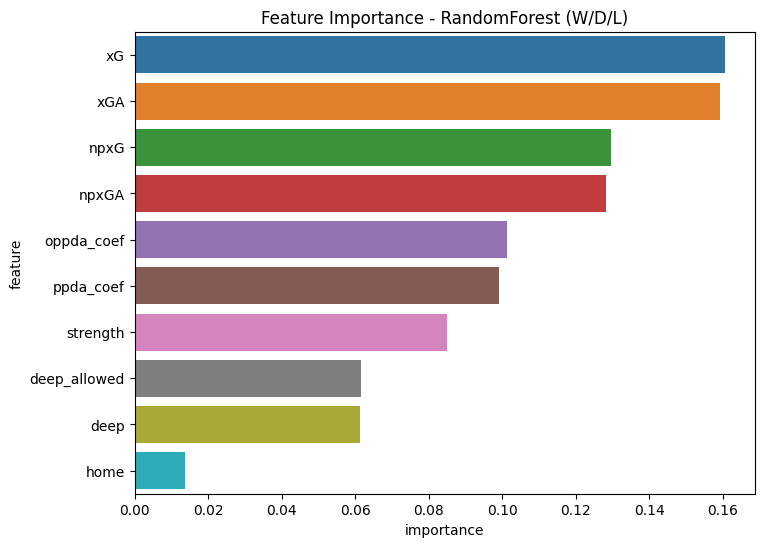

In [45]:
importances = clf.feature_importances_
feat_imp_df = pd.DataFrame({'feature': features_classif, 'importance': importances})
feat_imp_df.sort_values('importance', ascending=False, inplace=True)

print("\n=== Feature importance (RandomForest - klasyfikacja) ===")
print(feat_imp_df)

# Wizualizacja
plt.figure(figsize=(8,6))
sns.barplot(data=feat_imp_df, x='importance', y='feature', orient='h')
plt.title("Feature Importance - RandomForest (W/D/L)")
plt.show()


In [46]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as mc

# Przyjmujemy, że df zawiera kolumny 'xG' oraz 'result' (z wartościami 'W', 'D', 'L')
# Usuwamy brakujące wartości
df_anova = df[['xG', 'result']].dropna()

# Konwersja zmiennej result do typu kategorii (dla statsmodels)
df_anova['result'] = df_anova['result'].astype('category')

# Budujemy model liniowy – ANOVA
model = smf.ols('xG ~ C(result)', data=df_anova).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print("Tabela ANOVA dla xG:")
print(anova_table)

# Test post-hoc Tukeya
tukey = mc.pairwise_tukeyhsd(endog=df_anova['xG'],
                             groups=df_anova['result'],
                             alpha=0.05)
print("\nTest post-hoc Tukeya dla xG:")
print(tukey)




Tabela ANOVA dla xG:
                sum_sq      df           F  PR(>F)
C(result)  1299.610363     2.0  995.613075     0.0
Residual   4216.890458  6461.0         NaN     NaN

Test post-hoc Tukeya dla xG:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     d      l  -0.2781   0.0 -0.3391 -0.2171   True
     d      w   0.7305   0.0  0.6695  0.7915   True
     l      w   1.0086   0.0  0.9544  1.0629   True
---------------------------------------------------


In [47]:
# Przykład: korelacja między xG a deep
x = df['xG'].dropna()
y = df['deep'].dropna()

# Aby mieć pewność, że obie serie mają te same indeksy:
common_index = x.index.intersection(y.index)
x_common = x.loc[common_index]
y_common = y.loc[common_index]

rho, p_spearman = stats.spearmanr(x_common, y_common)
tau, p_kendall = stats.kendalltau(x_common, y_common)
print(f"Spearman correlation: rho = {rho:.4f}, p-value = {p_spearman:.4f}")
print(f"Kendall tau: tau = {tau:.4f}, p-value = {p_kendall:.4f}")


Spearman correlation: rho = 0.5094, p-value = 0.0000
Kendall tau: tau = 0.3669, p-value = 0.0000


In [48]:
train_data , test_data
features_classif , target_classif   # = 'result'
X_train_classif , X_test_classif
y_train_classif , y_test_classif



(0       w
 1       l
 2       w
 3       w
 4       l
        ..
 6459    d
 6460    l
 6461    w
 6462    w
 6463    l
 Name: result, Length: 5852, dtype: object,
 5508    l
 5509    w
 5510    l
 5511    d
 5512    w
        ..
 6115    l
 6116    w
 6117    w
 6118    l
 6119    l
 Name: result, Length: 612, dtype: object)

In [ ]:
# Kolmogorov–Smirnov: train_data
from scipy.stats import kstest, zscore
import pandas as pd

ks_rows = []
for col in features_classif:
    x = zscore(train_data[col].dropna())       # standaryzacja → porównujemy z N(0,1)
    ks_stat , p_val = kstest(x, 'norm')
    ks_rows.append({'feature': col,
                    'KS_stat': ks_stat,
                    'p_value': p_val})

ks_df = (pd.DataFrame(ks_rows)
           .sort_values('p_value')
           .reset_index(drop=True))
display(ks_df)


,feature,KS_stat,p_value
0,home,0.341345,0.000000e+00
1,strength,0.149620,7.952581e-115
2,ppda_coef,0.127802,8.726104e-84
3,oppda_coef,0.127802,8.726104e-84
4,deep,0.126793,1.806137e-82
5,deep_allowed,0.126793,1.806137e-82
6,npxG,0.082794,2.409015e-35
7,npxGA,0.082794,2.409015e-35
8,xG,0.076050,6.986878e-30
9,xGA,0.076050,6.986878e-30


In [ ]:
# MI: które cechy najlepiej różnicują W/D/L 
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif
import pandas as pd

le = LabelEncoder()
y_enc = le.fit_transform(y_train_classif)      # 0 = W  1 = D  2 = L
X_mi  = X_train_classif.values                # (n, 10)

mi_scores = mutual_info_classif(X_mi, y_enc,
                                discrete_features=False,
                                random_state=42)

mi_df = (pd.DataFrame({'feature': features_classif,
                       'MI': mi_scores})
           .sort_values('MI', ascending=False)
           .reset_index(drop=True))
display(mi_df)


,feature,MI
0,xG,0.134367
1,xGA,0.134175
2,npxG,0.123309
3,npxGA,0.123047
4,strength,0.046112
5,deep_allowed,0.032187
6,deep,0.026787
7,oppda_coef,0.020961
8,ppda_coef,0.020878
9,home,0.020702


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from scipy.stats import pearsonr
import pandas as pd
import numpy as np


# 1. Kodowanie zmiennej celu (W, D, L) → 0,1,2
#    — używamy tego samego encodera dla train i test
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train_classif)       # 0=W, 1=D, 2=L
y_test_enc  = le.transform(y_test_classif)            


# 2. Trening regresji logistycznej
log_clf = LogisticRegression(max_iter=500,
                             multi_class='multinomial',
                             random_state=42)
log_clf.fit(X_train_classif, y_train_enc)

print("ACC train:", accuracy_score(y_train_enc, log_clf.predict(X_train_classif)))
print("ACC test :", accuracy_score(y_test_enc , log_clf.predict(X_test_classif)))


# 3. Reszty probabilistyczne
probs_test = log_clf.predict_proba(X_test_classif)

# reszta = 1 − p(pred) dla prawdziwej klasy
resid = 1.0 - probs_test[np.arange(len(y_test_enc)), y_test_enc]

resid_df = pd.DataFrame({
    'residual'   : resid,
    'true_class' : y_test_enc
}, index=X_test_classif.index)

# 4. Korelacja reszt z cechami
corr_rows = []
for col in features_classif:
    r, p = pearsonr(resid_df['residual'], X_test_classif[col])
    corr_rows.append({'feature': col, 'r_resid': r, 'p_value': p})

corr_df = (pd.DataFrame(corr_rows)
             .sort_values('p_value')
             .reset_index(drop=True))
display(corr_df.head(10))


# 5. Największe wpadki modelu
worst10 = resid_df.sort_values('residual', ascending=False).head(10)

# Upewniamy się, że indexy worst10 są w train_data + test_data
source_df = pd.concat([train_data, test_data])        # pełny zbiór

display(pd.concat([source_df.loc[worst10.index, features_classif],
                   worst10], axis=1))


ACC train: 0.6267942583732058
ACC test : 0.6274509803921569


,feature,r_resid,p_value
0,npxGA,-0.156780,0.000098
1,npxG,-0.156334,0.000103
2,xGA,-0.148322,0.000231
3,xG,-0.145900,0.000293
4,oppda_coef,-0.108198,0.007383
5,ppda_coef,-0.105752,0.008840
6,strength,-0.102414,0.011242
7,deep,-0.070087,0.083193
8,deep_allowed,-0.060953,0.132016
9,home,-0.006063,0.881020


,xG,xGA,npxG,npxGA,deep,deep_allowed,ppda_coef,oppda_coef,home,strength,residual,true_class
5698,1.075910,5.056290,1.075910,5.056290,4,9,9.473684,7.538462,0,1.161765,0.988826,0
5699,5.056290,1.075910,5.056290,1.075910,9,4,7.538462,9.473684,1,1.372093,0.984470,0
5711,2.906460,0.634004,2.906460,0.634004,15,9,8.476190,12.538462,0,1.775194,0.983277,1
5710,0.634004,2.906460,0.634004,2.906460,9,15,12.538462,8.476190,1,1.687117,0.979260,2
5600,0.542933,2.161300,0.542933,2.161300,3,9,16.600000,11.045455,1,0.888889,0.966827,2
5919,3.063610,1.315880,3.063610,1.315880,12,1,8.750000,22.529412,1,2.607362,0.964009,1
6112,1.463150,2.701140,1.463150,2.701140,7,9,15.000000,8.777778,1,0.888889,0.952359,2
6007,2.953330,1.828650,2.953330,1.828650,10,2,16.150000,15.550000,1,2.607362,0.949848,1
5778,0.952662,2.818060,0.952662,2.060280,7,7,10.952381,29.363636,0,0.970588,0.942756,0
5734,1.340970,2.868690,1.340970,2.868690,5,11,18.687500,8.619048,0,1.123288,0.942114,2


In [52]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
import statsmodels.api as sm
import pandas as pd

X_vif = X_train_classif.copy()    # (n, 10)
vif_rows = []
for i, col in enumerate(features_classif):
    vif_rows.append({'feature': col,
                     'VIF': vif(X_vif.values, i)})
vif_df = pd.DataFrame(vif_rows).sort_values('VIF', ascending=False)
display(vif_df)


,feature,VIF
0,xG,36.558572
2,npxG,36.515012
3,npxGA,36.409486
1,xGA,36.357690
9,strength,13.097522
4,deep,5.904151
5,deep_allowed,5.361433
7,oppda_coef,4.983893
6,ppda_coef,4.302913
8,home,2.412813
